# Lab 1: Radiometric & Geometric Correction

**Instructor:** Muhammad Sayed  
**Semester:** Spring 2026

---

### Students Information

#### Student 1

**Name:** Nesma Osama
**ID:** 9220912

#### Student 2

**Name:** Mohamed Ashraf 
**ID:** 9220658

---

### Environment Setup Instructions
To ensure smooth execution, we will use a single unified Python 3.12 environment. Please run the following commands in your terminal.

**Windows (PowerShell):**
```bash
cd $HOME
py -3.12 -m venv rssi_env
.\rssi_env\Scripts\Activate
pip install --upgrade pip
pip install ipykernel rasterio earthpy scipy matplotlib numpy
python -m ipykernel install --user --name=rssi_env --display-name "Python (RSSI 2026)"
```

**Mac/Linux:**
```bash
cd ~
python3.12 -m venv rssi_env
source rssi_env/bin/activate
pip install --upgrade pip
pip install ipykernel rasterio earthpy scipy matplotlib numpy
python -m ipykernel install --user --name=rssi_env --display-name "Python (RSSI 2026)"
```

**Select the Kernel:**
Refresh this page, go to the Kernel menu, and select **Python (RSSI 2026)**.

---

### Learning Objectives
* **Real Data Handling:** Work with actual Landsat 8 GeoTIFFs.
* **Vectorization:** Process pixels using NumPy and SciPy, strictly avoiding Python for loops.
* **Physical Modeling:** Understand the physics of Rayleigh Scattering (Haze) and Sensor Noise.
* **Quantitative Metrics:** Evaluate restoration quality using L1 Loss against a ground truth.


In [12]:
import os
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from scipy.ndimage import convolve

### Data Acquisition and Visualization
The dataset consists of a 12-band Sentinel-2 image over Cairo.
* **Student Input:** Contains atmospheric haze, random shot noise (1%), and specific line striping artifacts.
* **Ground Truth:** A calibrated Level-2A surface reflectance image.

We will define a helper function to visualize the RGB bands (Red=B4, Green=B3, Blue=B2) to identify these artifacts.


Data Loaded. Shape: (12, 519, 519)


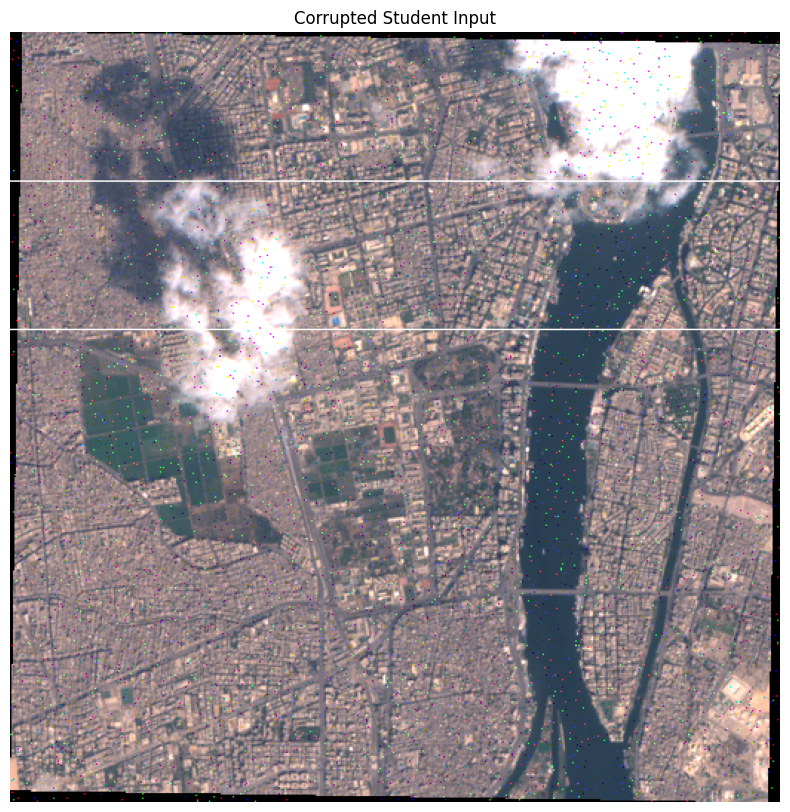

In [13]:
# Define paths
input_path = os.path.join("student_data", "lab1_student_input.tif")
gt_path = os.path.join("student_data", "lab1_ground_truth.tif")

def show_rgb(data, title):
    # Sentinel-2 RGB indices: Red (3), Green (2), Blue (1)
    # Transpose from (Bands, Height, Width) -> (Height, Width, Bands)
    rgb = data[[3, 2, 1], :, :].transpose(1, 2, 0)
    
    # Normalize for display (Clip at 3000 reflectance)
    rgb_norm = np.clip(rgb / 3000.0, 0, 1)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(rgb_norm)
    plt.title(title)
    plt.axis('off')
    plt.show()

if os.path.exists(input_path):
    with rasterio.open(input_path) as src:
        student_input = src.read().astype(float)
        profile = src.profile
    
    with rasterio.open(gt_path) as src:
        ground_truth = src.read().astype(float)

    print(f"Data Loaded. Shape: {student_input.shape}")
    show_rgb(student_input, "Corrupted Student Input")
else:
    print("Error: student_data files not found.")

### Task 1: Bad Pixel Correction (Salt & Pepper)

**Physics:**
Sensor detectors occasionally fail (reporting 0) or saturate (reporting max value). This creates high-frequency noise known as Salt and Pepper.

**Requirements:**
* Identify pixels that are exactly 0 (Pepper) or > 9000 (Salt).
* Use a convolution kernel (e.g., 3x3 mean) to calculate the average of neighbors.
* Replace **only** the identified bad pixels with the averaged values.
* **Constraint:** Do not use for loops. Use `np.where`.

**Grading:** 3 Marks


Bad pixels corrected.


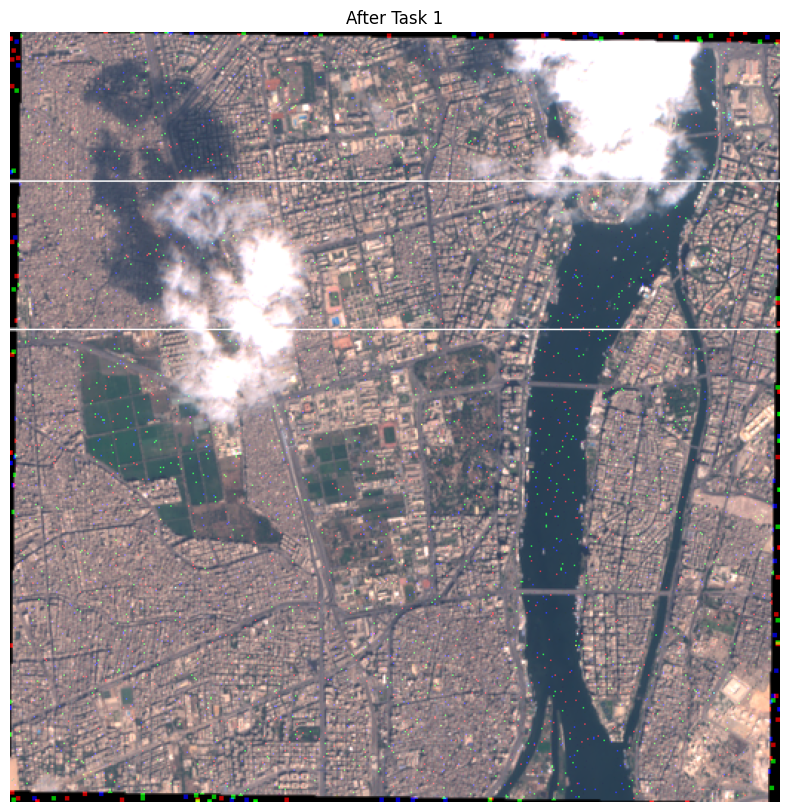

In [14]:
# Task 1 Implementation
task1_result = student_input.copy()
# TODO: Create a boolean mask for bad pixels (0 or > 9000)
mask = (task1_result==0)|(task1_result>9000)
# TODO: Create a 3x3 averaging kernel (all ones / 9)
kernel = np.ones((3,3))/9.0

# TODO: Apply convolution to the entire image to get smoothed values
smoothed = convolve(task1_result,kernel,mode="reflect",axes=(1,2))

# TODO: Use np.where to replace bad pixels in task1_result with smoothed values
task1_result = np.where(mask,smoothed,task1_result)

print("Bad pixels corrected.")
show_rgb(task1_result, "After Task 1")

### Task 2: Destriping (Sensor Bias)

**Physics:**
A specific detector in the pushbroom scanner has a calibration error, adding a constant bias to specific rows. Visually inspect the image to find the bright horizontal lines.

**Requirements:**
* Identify the row indices containing the stripe artifacts (Hint: Check rows 100 and 200).
* Identify which bands are affected (Hint: Check RGB bands).
* Subtract the bias value (estimated at 5000) from these specific rows.
* Clip values to ensure they do not go below 0.

**Grading:** 2 Marks


Striping removed.


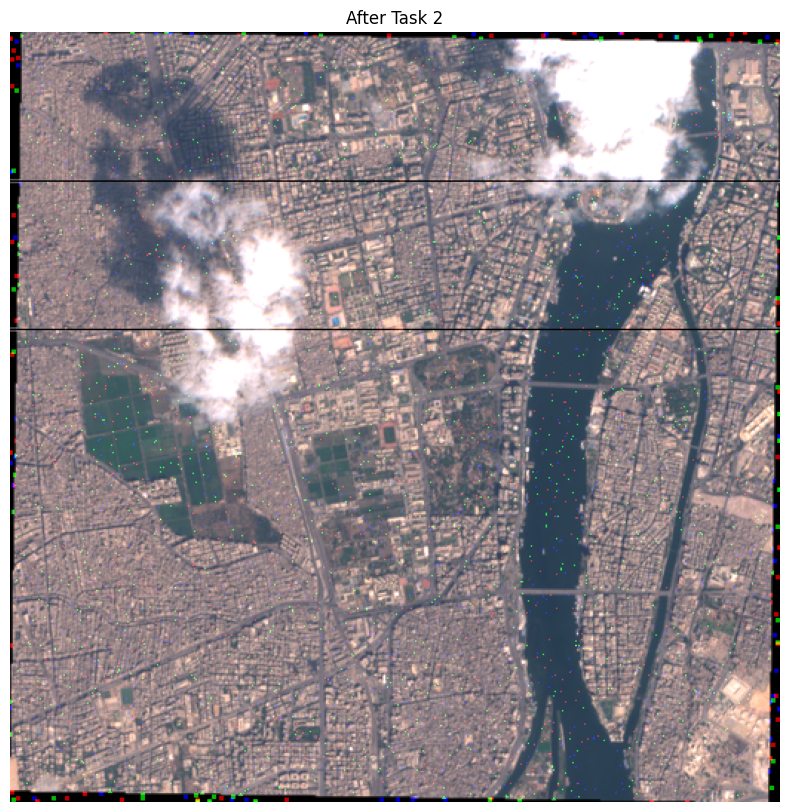

In [15]:
# Task 2 Implementation
task2_result = task1_result.copy()
# TODO: Subtract bias (5000) from the specific rows (100 and 200) in RGB bands (1, 2, 3)
task2_result[1:4,[100,200],:] -= 5000
# TODO: Clip negative values to 0
task2_result = np.clip(task2_result,0,None)

print("Striping removed.")
show_rgb(task2_result, "After Task 2")

### Task 3: Atmospheric Correction (Dark Object Subtraction)

**Physics:**
Atmospheric scattering adds a "path radiance" (Haze) to the image, shifting the histogram away from zero. We assume the darkest pixels in the scene should be zero.

**Requirements:**
* Calculate the 0.1 percentile for each band to estimate the haze bias.
* Subtract this bias from the entire band.
* Clip negative values to 0.

**Grading:** 3 Marks


Haze removed.


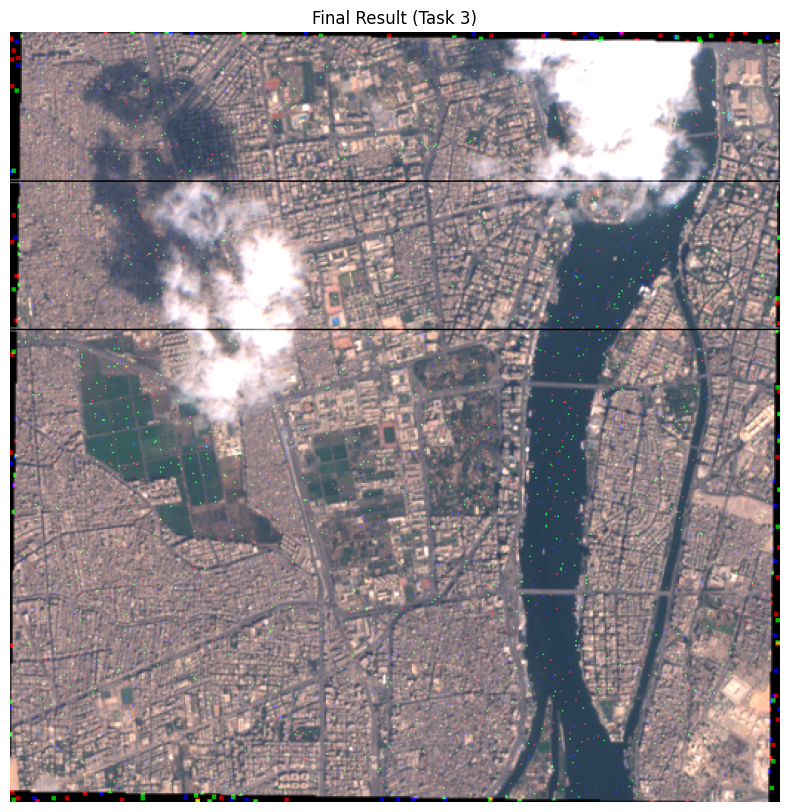

In [16]:
# Task 3 Implementation
final_result = task2_result.copy()

# Iterate over bands (Vectorized per band)
# TODO: Find the 0.1 percentile for this band
bias = np.percentile(final_result, 0.1, axis=(1, 2), keepdims=True)

# TODO: Subtract bias
final_result -= bias

# Clip final result
final_result = np.clip(final_result, 0, None)

print("Haze removed.")
show_rgb(final_result, "Final Result (Task 3)")

### Evaluation

Calculate the Mean Absolute Error (L1 Loss) between your cleaned image and the Ground Truth.

**Grading:** 2 Marks (For calculating and displaying the metric)


In [17]:
# TODO: Normalize the data to range [0, 1]
min_val = ground_truth.min()
max_val = ground_truth.max()

final_result_norm = (final_result - min_val) / (max_val - min_val)
ground_truth_norm = (ground_truth - min_val) / (max_val - min_val)

# TODO: Calculate difference
diff = final_result_norm - ground_truth_norm

# TODO: Calculate L2 Loss (Mean Squared Error)
l2_loss = np.mean(diff ** 2)

# TODO: Calculate RMSE (Root Mean Squared Error)
rmse = np.sqrt(l2_loss)

# TODO: Calculate L1 Loss (Mean Absolute Error)
l1_loss = np.mean(np.abs(diff))


print("\n" + "="*40)
print(f"ERROR METRICS REPORT")
print("="*40)
print(f"Mean Squared Error (L2 Loss):  {l2_loss:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")
print("-" * 20)
print(f"Mean Absolute Error (L1 Loss): {l1_loss:.3f}")
print("="*40 + "\n")


ERROR METRICS REPORT
Mean Squared Error (L2 Loss):  0.002173
Root Mean Squared Error (RMSE): 0.047
--------------------
Mean Absolute Error (L1 Loss): 0.028

